# Radio flux density calibration of Hydra A @ 12 GHz


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/b1/b1r9z14x65s4cj4hkxzhkdqc0000gn/T/ipykernel_26725/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Please note:

The data you will be processing in this and other tutorials is located in the "data" folder. In there you will
find fits files for your calibrator [Hydra A](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NAME%20HYDRA%20A)


Listed below are the steps we are going to follow to calibrate our source

# <a name="top"></a>Task list:

1. [Locate and open the observation file](#section1)
2. [Examine the fits file](#section2)
3. [Extract the drift scan data](#section3)
4. [How the system calibration works](#section4)
5. [Measure the antenna temperature](#section5)
 * 5.1 [Convert counts to units of Kelvin](#section5.1)
 * 5.2 [Fit a baseline to remove systemic contributions](#section5.2)
 * 5.3 [Fit beam to get antenna temperature](#section5.3)
 * 5.4 [Amplitude correction](#section5.4)
6. [Calculate the point source sensitivity (PSS)](#section6)
7. [Got to target flux](12GHz_j1427-4206_tutorial.ipynb)

# 1. <a name="section1">Locate and open the observation file</a> 
[back to top](#top)

Select an observation to work on and open the fits file

* The Python standard library has a [pyfits package](http://docs.astropy.org/en/stable/io/fits/index.html) we use for reading and writing FITS files and manipulating their contents. Fits files store information about a source observation in what it calls header data units (HDUs). We are going to load the package in order to begin processing our preferred file. You can read up on all the other interesting file manipulation methods by clicking on the link above.



In [2]:
import astropy.io.fits as pyfits
fitsfile = 
hdulist  = pyfits.open(fitsfile) 

In [3]:
# pip install astropy

# 2. <a name="section2">Examine the fits file</a>
[back to top](#top)

It is always a good idea to familiarize yourself with the file contents by viewing the different types of information inside your file. To get an overview of the contents we use the info() method


In [4]:
hdulist.info()

Filename: data/HydraA/12GHz/2013d125_15h48m00s_Cont_mike_HYDRA_A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   ()      
  1  02.5S         1 BinTableHDU     60   1R x 13C   [1D, 1D, 1D, 8A, 1D, 8A, 1D, 25A, 1D, 1D, 28A, 1D, 1D]   
  2  Scan_0_HPNZ_CAL    1 BinTableHDU    107   128R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  3  Scan_1_HPNZ    1 BinTableHDU     95   784R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  4  Scan_2_ZC     1 BinTableHDU     95   784R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  5  Scan_3_HPSZ    1 BinTableHDU     95   784R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  6  Chart         1 BinTableHDU     40   3999R x 3C   [1D, 1D, 1D]   


The info() method gives us a list of all the HDUs in this file. 

* The first header data unit (HDU) contains information on the  observation.  
* The second one has information on the 2.5 cm (i.e. 12 GHz) feed system. This data is not necessarily up to date, so we generally disregard it. 
* The third unit has the noise diode firing, used to convert from raw counts to Kelvins. 
* The next three binary tables are the drift scans themselves, starting at the north offset position.
* The last HDU contains more information about the observation.

To view the content inside an HDU we use indexes. For example, to view the PRIMARY HDU, we use index 0.


In [5]:
hdulist[0].header

# You can play around with changing the indeces to see what 
# other information is stored in the other HDUs

SIMPLE  =                    T                                                  
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T                                                  
DATE    = '2013-05-05T15:48:00' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
COMMENT information about the object, from scheduler task                       
OBJECT  = 'HYDRA A '           / Name of object                                 
LONGITUD=            139.52375 / Longitude of object                            
LATITUDE=    -12.0955555555556 / Latitude of object                             
COORDSYS= 'EQUATORIAL'         / Input coordinate system                        
EQUINOX =                2000. / Input coordinate equinox                       
RADECSYS= 'ICRS    '           / Input reference frame                          
COMMENT information about th

# 3. <a name="section3">Extract the drift scan data</a>

[back to top](#top)

The 26-m telescope has slight variations in pointing, so in order to make sure we accurately measure the peak flux of the source, we do a series of drift scans at the expected north and south half-power points, as well as the centre. 
Basically we park the telescope at a coordinate just ahead of where the source currently is in the sky, and wait for earth's rotation to carry the telescope beam across the source. The advantage of this is that you don't have to worry about whether your telescope can drive at a consistent speed across the source. The 26-m tracks perfectly at sidereal rate, but is not very good at higher speeds. Other telescopes may choose to use on-the-fly scans, where they sample the power at a high rate while slewing across the source.



In [6]:
drift1 = hdulist[3] #HPN
drift2 = hdulist[4] #ON
drift3 = hdulist[5] #HPS

Lets view the drift1 HDU to see the file contents

In [7]:
drift1.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  184 / width of table in bytes                        
NAXIS2  =                  784 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   23 / number of fields in each row                   
EXTNAME = 'Scan_1_HPNZ'        / name of this binary table extension            
FRONTEND= '02.5S   '           / Frontend ID                                    
CENTFREQ=            12218.593 / [MHz] Backend centre frequency                 
BANDWDTH=                 400. / [MHz] Bandwidth of backend                     
SCANTYPE= 'Drift   '        

Most of the fields are actually just the position in different formats. We are interested in the output signal '**Count1**' and '**Count2**'.  

# 4. <a name="section4">How do we calibrate our system ? </a>
[back to top](#top)

A noise diode, when activated, generates a consistent signal corresponding to a temperature $T_{cal}$(K). We use this signal to calibrate the system, enabling us convert from raw counts (or voltage, as the case may be) to Kelvins.  


##### Let's take a look at our noise diodes

In [8]:
hdulist[0].header

SIMPLE  =                    T                                                  
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T                                                  
DATE    = '2013-05-05T15:48:00' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
COMMENT information about the object, from scheduler task                       
OBJECT  = 'HYDRA A '           / Name of object                                 
LONGITUD=            139.52375 / Longitude of object                            
LATITUDE=    -12.0955555555556 / Latitude of object                             
COORDSYS= 'EQUATORIAL'         / Input coordinate system                        
EQUINOX =                2000. / Input coordinate equinox                       
RADECSYS= 'ICRS    '           / Input reference frame                          
COMMENT information about th

In [9]:
# Get the noise diode calibration HDU
noise_cal = hdulist[2]
noise_cal.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  184 / width of table in bytes                        
NAXIS2  =                  128 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   23 / number of fields in each row                   
EXTNAME = 'Scan_0_HPNZ_CAL'    / name of this binary table extension            
FRONTEND= '02.5S   '           / Frontend ID                                    
CENTFREQ=            12218.593 / [MHz] Backend centre frequency                 
BANDWDTH=                 400. / [MHz] Bandwidth of backend                     
TCAL1   =                11.

In [10]:
#Import plotting libraries
import matplotlib.pyplot as plt

#display figures inline 
%matplotlib inline  

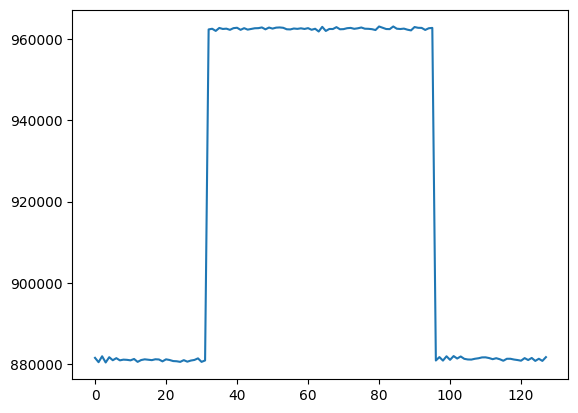

In [11]:
plt.plot(noise_cal.data['Count1'])

##### What do we want to do? 
- We want to measure the amplitude of the jump between the system level counts and the noise diode firing. 

We're going to detect at which index the jumps occur, and we can either fit a linear function to the two sections, or simply take the mean.  In most cases, the counts should remain very stable for the duration of the noise diode calibration cycle. The noise diode values are give in the header of the file as TCAL1 and TCAL2 for the two channels (which correspond to left and right circular).

The diff function will calculate the difference between adjacent values in an array. This is a quick way to find where there are abrupt changes in a data-series.

In [12]:
import numpy as np

# print measured counts
#print(noise_cal.data['Count1'])

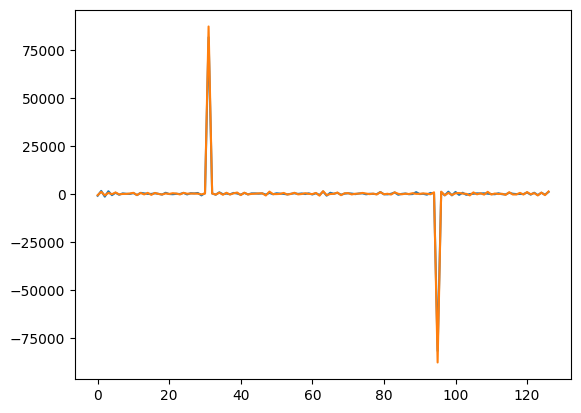

In [13]:
jumps1 = np.diff(noise_cal.data['Count1'])
jumps2 = np.diff(noise_cal.data['Count2'])
plt.plot(jumps1) 
plt.plot(jumps2) 

The spike corresponds to when the noise diode turns on.  The drop corresponds to when the noise diode turns off.

In [14]:
import os
from scipy import stats

Counts per Kelvin for channel 1 is 6977.09 +- 56.82


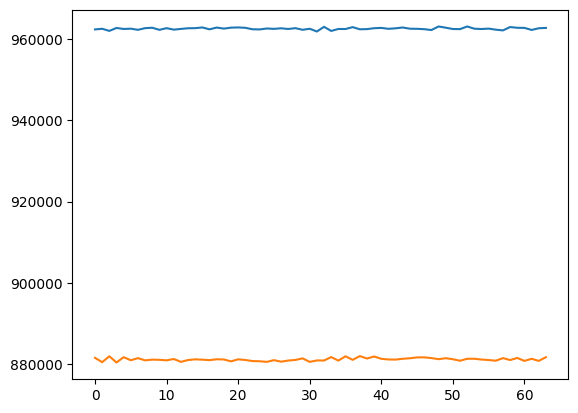

In [15]:
#find the array indices at which the noise diode turns on and off for channel 1
nd_on_pos1 = np.argmax(jumps1)+1
nd_off_pos1 = np.argmin(jumps1)+1

#there are two segments where the noise diode is off.  We concatenate these two segments
nd_off_count1 = np.concatenate((noise_cal.data['Count1'][:nd_on_pos1], noise_cal.data['Count1'][nd_off_pos1:]))
nd_off_mean1 = np.mean(nd_off_count1)
nd_off_sem1 = stats.sem(nd_off_count1)

nd_on_count1 = noise_cal.data['Count1'][nd_on_pos1:nd_off_pos1]
nd_on_mean1 = np.mean(nd_on_count1)
nd_on_sem1 = stats.sem(nd_on_count1)
err_1 = np.sqrt(nd_on_sem1**2 + nd_off_sem1**2)

#verify that our selection criteria were correct
plt.plot(nd_on_count1)
plt.plot(nd_off_count1)

#counts per Kelvin
count_K1 = (nd_on_mean1 - nd_off_mean1)/noise_cal.header['TCAL1']
print('Counts per Kelvin for channel 1 is %.2f +- %.2f'%(count_K1, err_1))



Counts per Kelvin for channel 2 is 6863.25 +- 56.38


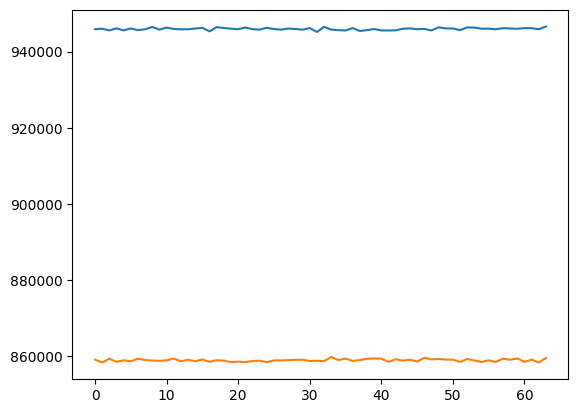

In [16]:
#repeat for second polarisation

#find the array indices at which the noise diode turns on and off for channel 2
nd_on_pos2 = np.argmax(jumps2)+1
nd_off_pos2 = np.argmin(jumps2)+1
#there are two segments where the noise diode is off.  We concatenate these two segments
nd_off_count2 = np.concatenate((noise_cal.data['Count2'][:nd_on_pos2], noise_cal.data['Count2'][nd_off_pos2:]))
nd_off_mean2 = np.mean(nd_off_count2)
nd_off_sem2 = stats.sem(nd_off_count2)

nd_on_count2 = noise_cal.data['Count2'][nd_on_pos2:nd_off_pos2]
nd_on_mean2 = np.mean(nd_on_count2)
nd_on_sem2 = stats.sem(nd_on_count2)
err_2 = np.sqrt(nd_on_sem2**2 + nd_off_sem2**2)

#verify that our selection criteria were correct
plt.plot(nd_on_count2)
plt.plot(nd_off_count2)
#counts per Kelvin
count_K2 = (nd_on_mean2 - nd_off_mean2)/noise_cal.header['TCAL2']
print('Counts per Kelvin for channel 2 is %.2f +- %.2f'%(count_K2, err_2))

This was just a demonstration of what is being done by the online system.  The same conversion (labelled HzperK) is already in the header.

# 5. <a name="section5">Measure the antenna temperature</a>
[back to top](#top)

## 5.1 <a name="section5.1">Convert counts to units of Kelvin </a>
[back to top](#top)

In [17]:
# Construct an array for the x-axis in terms of right ascension
ra = drift1.data['RA_J2000']

# Get conversion factors
count_K1 = noise_cal.header['HZPERK1']
count_K2 = noise_cal.header['HZPERK2']

# Get source counts and convert counts to antenna temperature
north_scan_LCP = (drift1.data['Count1']/count_K1) - ((drift1.data['Count1'])[0]/count_K1) 
north_scan_RCP = (drift1.data['Count2']/count_K2) - ((drift1.data['Count2'])[0]/count_K2)
on_scan_LCP    = (drift2.data['Count1']/count_K1) - ((drift2.data['Count1'])[0]/count_K1)
on_scan_RCP    = (drift2.data['Count2']/count_K2) - ((drift2.data['Count2'])[0]/count_K2)
south_scan_LCP = (drift3.data['Count1']/count_K1) - ((drift3.data['Count1'])[0]/count_K1)
south_scan_RCP = (drift3.data['Count2']/count_K2) - ((drift3.data['Count2'])[0]/count_K2)
            

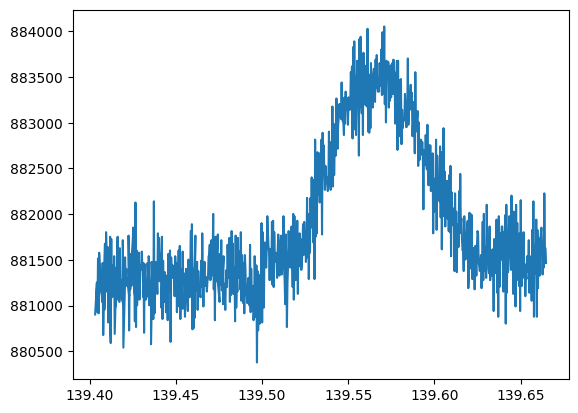

In [18]:
plt.plot(ra,drift1.data['Count1'])

Plot the data

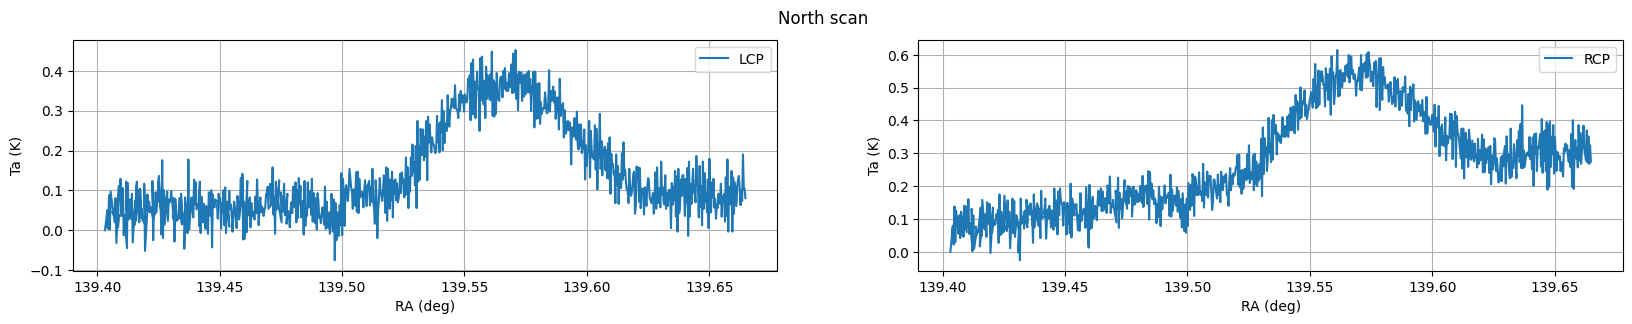

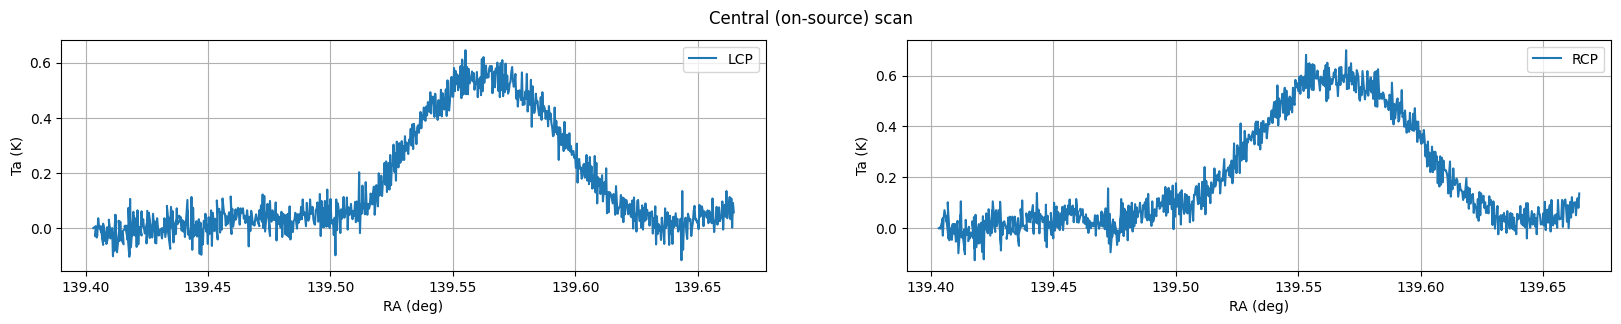

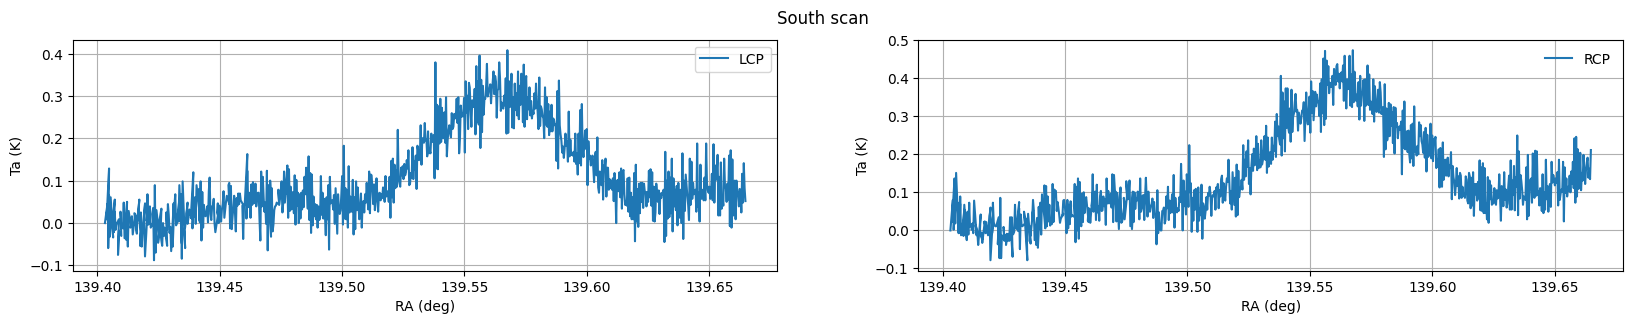

In [19]:
# HPN 
plt.figure(figsize=[20,3])
plt.suptitle('North scan')

ax = plt.subplot(121)
plt.grid()
plt.plot(ra, north_scan_LCP, label = 'LCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

ax = plt.subplot(122)
plt.grid()
plt.plot(ra, north_scan_RCP, label = 'RCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

# ON
plt.figure(figsize=[20,3])
plt.suptitle('Central (on-source) scan')

ax = plt.subplot(121)
plt.grid()
plt.plot(ra, on_scan_LCP, label = 'LCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

ax = plt.subplot(122)
plt.grid()
plt.plot(ra, on_scan_RCP, label = 'RCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

# HPS
plt.figure(figsize=[20,3])
plt.suptitle('South scan')

ax = plt.subplot(121)
plt.grid()
plt.plot(ra, south_scan_LCP, label = 'LCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

ax = plt.subplot(122)
plt.plot(ra, south_scan_RCP, label = 'RCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend(frameon=False)
plt.grid()
lim = plt.axis('tight')



What can we tell about the telescope by looking at this observation?

The pointing is slightly off. If we had a perfect pointing model, the peak of the scan would always be at the center of the scan, and the north and south offset scans would have half the power of the central scan (ON). 



## 5.2 <a name="section5.2">Fit a baseline to remove systemic contributions</a>
[back to top](#top)

We are only interested in the temperature contributed by the source, so we want to subract off the system temperature contribution.  We see that the baseline level changes through during the scan.

What do we fit then?  This is a fairly strong source, we can clealy see the antenna beam pattern.  Looking carefully we can see a deflection point at the base of the beam.  This is the first null of the beam. At these points we will not be receiving any power from the source.


Locate the section you want to use for your fit. We are going to write a few methods to help us process the location selection for our fit

In [20]:
def getBasePts(x, y,len_scan,x1,x2,x3,x4): 
    '''
        Get baseline points. Select points along the driftscan where you will fit
        your baseline.
    '''

    xbleft = x[x1:x2]
    ybleft = y[x1:x2]
    xbright= x[len_scan-x3:len_scan-x4]
    ybright= y[len_scan-x3:len_scan-x4]

    left_base_pts = list(xbleft) + list(xbright)
    right_base_pts = list(ybleft) + list(ybright)

    return left_base_pts, right_base_pts 


Fit the baseline and plot your data

In [21]:

def fitBasePts(x_base_pts,y_base_pts, x, y):
    """Fit the data to remove systematic contributions.
    """
        
    base_fit_coeffs = np.polyfit(x_base_pts, y_base_pts, 1)
    base_fit_line = np.polyval(base_fit_coeffs,x_base_pts)   
    data_fit = np.polyval(base_fit_coeffs, x)
    data_fit = y - data_fit
    
    res,rms = residual(y_base_pts,base_fit_line)
   
    print ("Fit = %.2fx + (%d), rms error = %.3f" %(base_fit_coeffs[0], base_fit_coeffs[1],rms))
    
    return data_fit, base_fit_line
    
# Get the residual and rms to estimate the errors in the fit
def residual(model, data): 
    
    from sklearn.metrics import mean_squared_error
    """
        Calculate the residual between the model and the data.
    """

    res = np.array(model - data)
    rms = np.sqrt(mean_squared_error(data,model))

    return res, rms

def fitBaselineAndPlot(x,y,title,x1,x2,x3,x4,len_scan):
    """
        Fit and plot your data
    """

    xb,yb = getBasePts(x,y,len_scan,x1,x2,x3,x4)
    
    # Fit the baseline points
    fit, base_fit_line = fitBasePts(xb,yb, x, y)

    # plot the data
    plt.figure(figsize=[20,3])
    plt.suptitle(title)

    ax = plt.subplot(121)
    plt.axhline(y=0, color='k', alpha= 0.5)
    l1,= plt.plot(x,y, label = 'original data')
    l2,= plt.plot(xb,yb,'r.', label = 'noise')
    plt.plot(xb,base_fit_line, 'g', label = "baseline fit")
    plt.xlabel('RA (deg)')
    plt.ylabel('Ta (K)')
    plt.legend()
    plt.grid()
    lim = plt.axis('tight')

    ax = plt.subplot(122)
    l1,= plt.plot(x,fit, label = 'final data')
    plt.xlabel('RA (deg)')
    plt.ylabel('Ta (K)')
    plt.axhline(y=0, color='k', alpha= 0.5)
    plt.legend()
    plt.grid()
    lim = plt.axis('tight')
    
    return fit



Y = mx + c
Fit = 0.32x + (-44), rms error = 0.048
Fit = 0.49x + (-68), rms error = 0.047
Fit = 0.17x + (-23), rms error = 0.046
Fit = 0.94x + (-131), rms error = 0.050
Fit = 0.16x + (-22), rms error = 0.043
Fit = 0.21x + (-28), rms error = 0.044


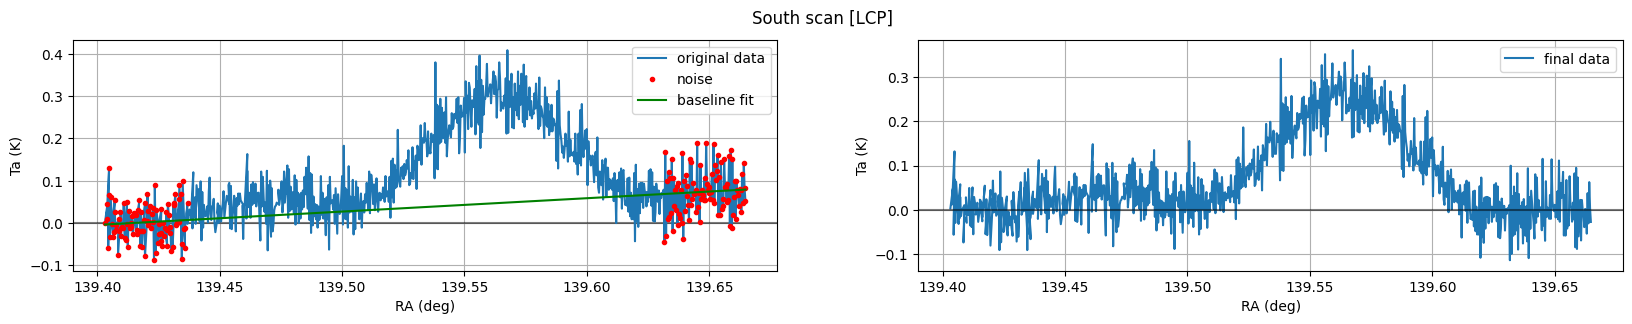

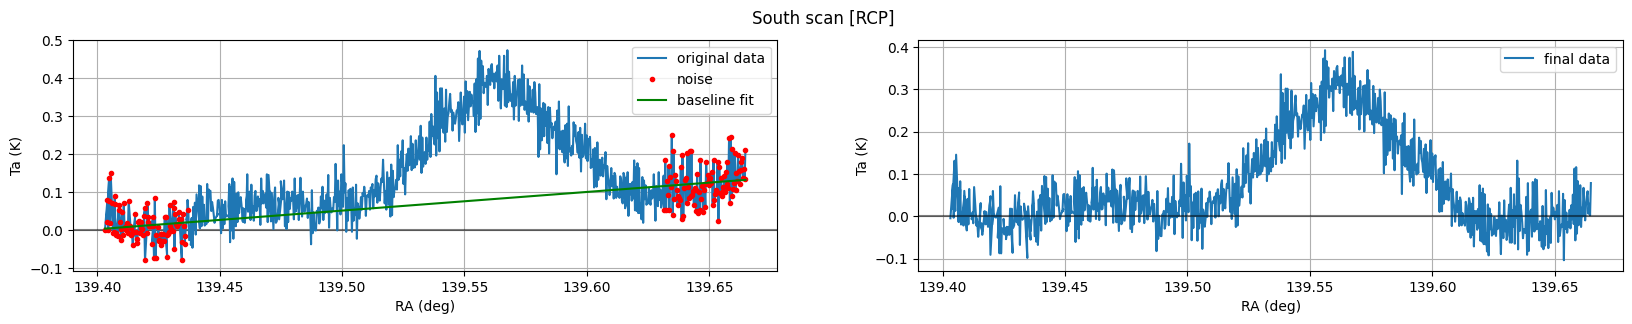

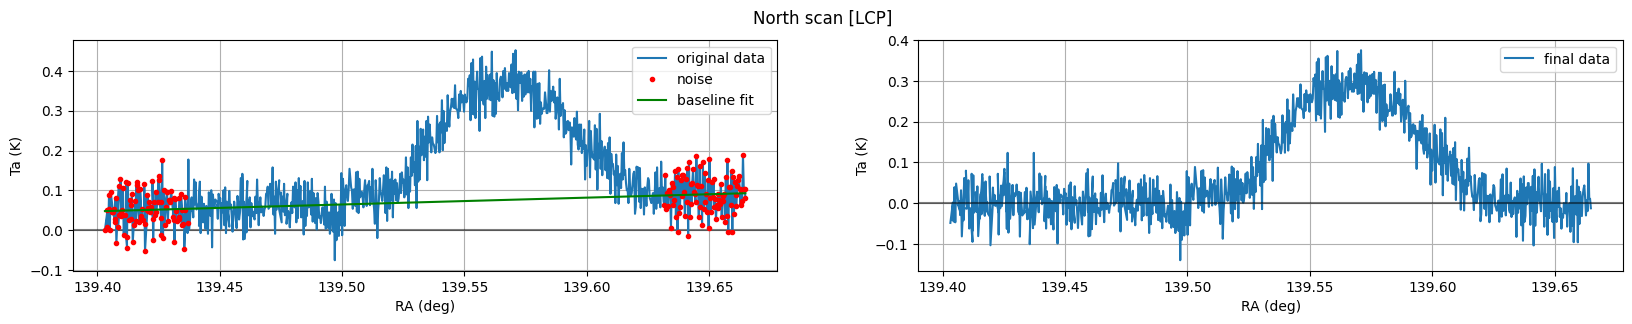

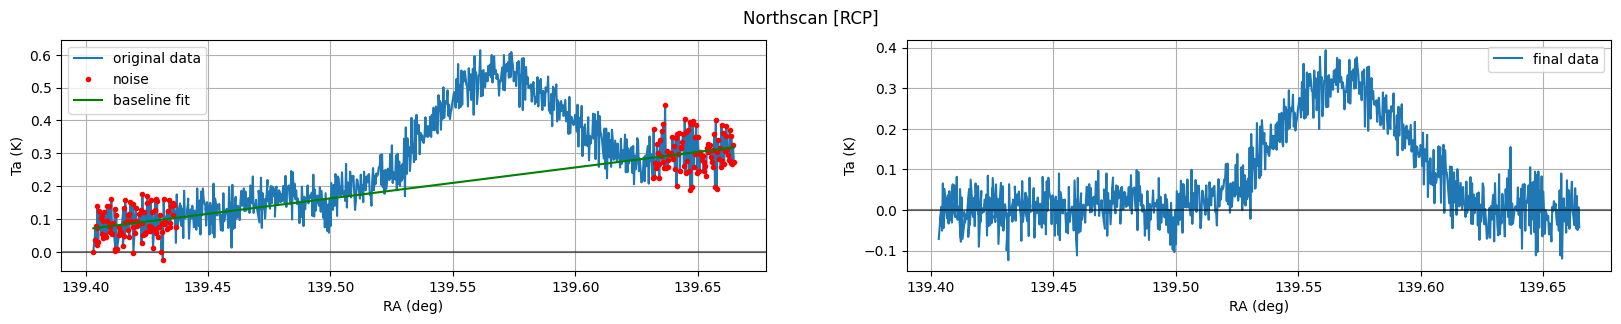

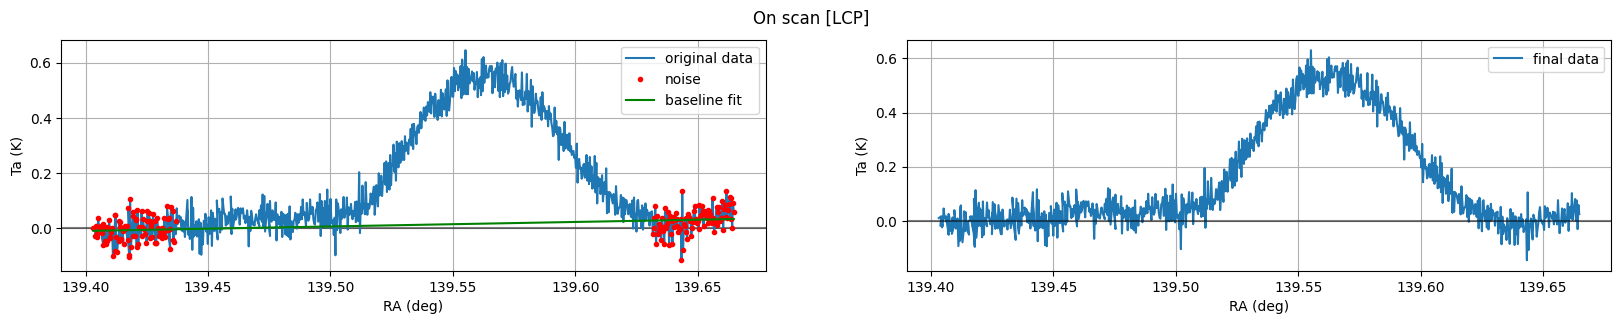

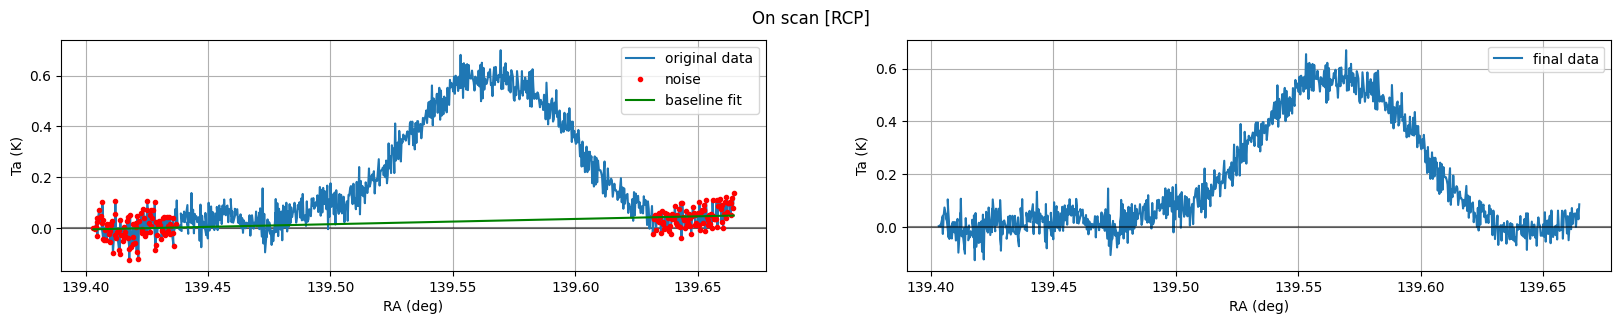

In [22]:
# Get the length of the scans
len_scan = len(ra)

# Set the baseline points, default is 100 points on each side
# You can change the x1-x4 values to adjust the location of
# your baseline fit.

 # YOU CAN MODIFY THESE VALUES
x1 = 0
x2 = 100
x3 = 100
x4 = 0
    
print ("Y = mx + c")

# Fit and plot 
slcp  = fitBaselineAndPlot(ra, south_scan_LCP, 'South scan [LCP]',x1,x2,x3,x4,len_scan)
srcp  = fitBaselineAndPlot(ra, south_scan_RCP, 'South scan [RCP]',x1,x2,x3,x4,len_scan)
nlcp  = fitBaselineAndPlot(ra, north_scan_LCP, 'North scan [LCP]',x1,x2,x3,x4,len_scan)
nrcp  = fitBaselineAndPlot(ra, north_scan_RCP, 'Northscan [RCP]' ,x1,x2,x3,x4,len_scan)
onlcp = fitBaselineAndPlot(ra, on_scan_LCP   , 'On scan [LCP]'   ,x1,x2,x3,x4,len_scan)
onrcp = fitBaselineAndPlot(ra, on_scan_RCP   , 'On scan [RCP]'   ,x1,x2,x3,x4,len_scan)

## For discussion ?

* If you were automating this process, how would you check that the fit was good, and what would you do if it wasn't?
* Is a first-order polynomial fit good enough to correct the baseline drift?  Should we try a higher order in some cases?

Hydra A is partially resolved by the 26-m telescope, so what we see is not a perfect beam pattern. We don't get a perfect fit, but it can help us disentangle the various components and zoom in on an area in which we can do a  more specialised fit.

We have good estimates for the baseline as shown in the figures above.

## 5.3 <a name="section5.3">Fit beam to get antenna temperature</a>
[back to top](#top)

We are now going to fit the top of the beam to fit the 
antenna temperature. We will use a 2nd order polynomial fit
at the top of the peak. 

In [23]:
# Get location of peak
def getPeakPts(drift, percentage):
    """Get locations of scan peak where we are going to fit 
       We will be fitting the top 40% of our scan.
    """
    peak_frac = float((100.0 - percentage)/100.0)
    peak_max = max(drift)
    peak_pts = np.where(drift >= peak_frac * peak_max)[0]
    return peak_pts

# Fit the peak
def fitPeak(peak_pts, x, y):
    """Fit the peak and estimate errors.
    """

    peakfitcoeffs = np.polyfit(x[peak_pts], y[peak_pts], 2)
    peakfitline = np.polyval(peakfitcoeffs,x[peak_pts])
    res, rms = residual(peakfitline, y[peak_pts])

    return peakfitline, rms, x[peak_pts], y[peak_pts]

# Get peak points

# YOU CAN MODIFY THIS VALUE
peak_percentage = 50 # Change the percentage of the peak data you want to fit.

peak_pts_slcp = getPeakPts(slcp, peak_percentage)
peak_pts_srcp = getPeakPts(srcp, peak_percentage)
peak_pts_nlcp = getPeakPts(nlcp, peak_percentage)
peak_pts_nrcp = getPeakPts(nrcp, peak_percentage)
peak_pts_onlcp = getPeakPts(onlcp, peak_percentage)
peak_pts_onrcp = getPeakPts(onrcp, peak_percentage)

# Fit the peaks
fitpsl, slrms, xpslcp, ypslcp   = fitPeak(peak_pts_slcp, ra, slcp)
fitpsr, srrms, xpsrcp, ypsrcp    = fitPeak(peak_pts_srcp, ra, srcp)
fitpnl, nlrms, xpnlcp, ypnlcp    = fitPeak(peak_pts_nlcp, ra, nlcp)
fitpnr, nrrms, xpnrcp, ypnrcp    = fitPeak(peak_pts_nrcp, ra, nrcp)
fitponl, onlrms, xpolcp, ypolcp  = fitPeak(peak_pts_onlcp, ra, onlcp)
fitponr, onrrms, xporcp, yporcp  = fitPeak(peak_pts_onrcp, ra, onrcp)

# Print out the ANTENNA TEMPERATURES
print ('Ta_SLCP = %.3f +- %.3f [K]' %(max(fitpsl), slrms))
print ('Ta_SRCP = %.3f +- %.3f [K]' %(max(fitpsr), srrms))
print ('Ta_NLCP = %.3f +- %.3f [K]' %(max(fitpnl), nlrms))
print ('Ta_NRCP = %.3f +- %.3f K]' %(max(fitpnr), nrrms))
print ('Ta_ONLCP = %.3f +- %.3f [K]' %(max(fitponl), onlrms))
print ('Ta_ONRCP = %.3f +- %.3f [K]' %(max(fitponr), onrrms))


Ta_SLCP = 0.258 +- 0.038 [K]
Ta_SRCP = 0.290 +- 0.043 [K]
Ta_NLCP = 0.286 +- 0.037 [K]
Ta_NRCP = 0.309 +- 0.037 K]
Ta_ONLCP = 0.529 +- 0.039 [K]
Ta_ONRCP = 0.561 +- 0.041 [K]


Plot the fits

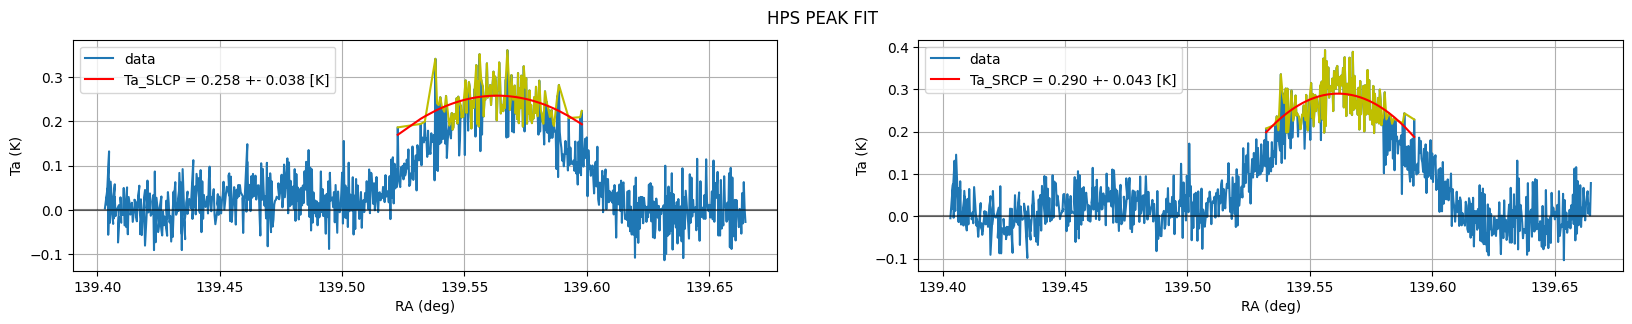

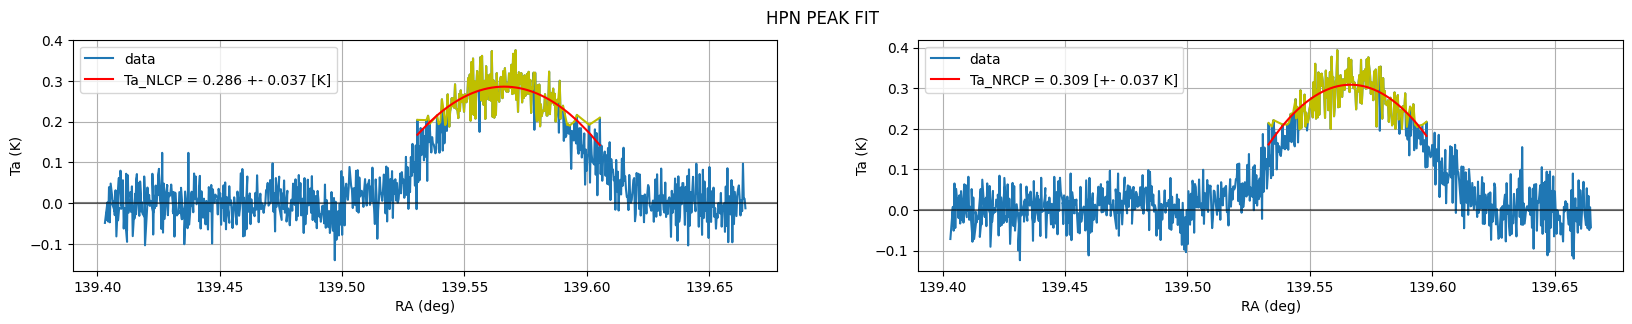

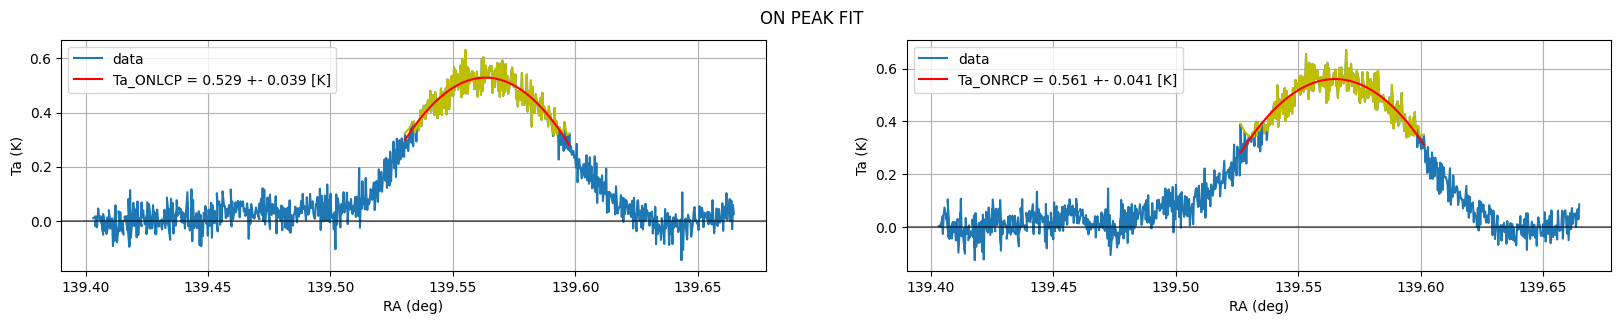

In [24]:
def plotFit(ra, drift1, title, peak_pts1,fit1,drift2, peak_pts2,fit2, lab1,lab2,xp1,yp1,xp2,yp2):
    
    # plot the data
    plt.figure(figsize=[20,3])
    plt.suptitle(title)

    ax = plt.subplot(121)
    l1,= plt.plot(ra,drift1, label = 'data')
    plt.plot(xp1,yp1,'y')
    l3,= plt.plot(ra[peak_pts1],fit1,'r', label=lab1)
    plt.xlabel('RA (deg)')
    plt.ylabel('Ta (K)')
    plt.legend()
    plt.axhline(y=0, color='k', alpha= 0.5)
    plt.grid()
    lim = plt.axis('tight')

    ax = plt.subplot(122)
    l1,= plt.plot(ra,drift2, label = 'data')
    plt.plot(xp2,yp2,'y')
    l3,= plt.plot(ra[peak_pts2],fit2, 'r',label = lab2)
    plt.xlabel('RA (deg)')
    plt.ylabel('Ta (K)')
    plt.axhline(y=0, color='k', alpha= 0.5)
    plt.legend()
    plt.grid()
    lim = plt.axis('tight')

plotFit(ra,slcp,'HPS PEAK FIT',peak_pts_slcp,fitpsl, srcp, peak_pts_srcp,fitpsr,'Ta_SLCP = %.3f +- %.3f [K]' %(max(fitpsl), slrms), 'Ta_SRCP = %.3f +- %.3f [K]' %(max(fitpsr), srrms), xpslcp, ypslcp, xpsrcp, ypsrcp )
plotFit(ra,nlcp,'HPN PEAK FIT',peak_pts_nlcp,fitpnl, nrcp, peak_pts_nrcp,fitpnr, 'Ta_NLCP = %.3f +- %.3f [K]' %(max(fitpnl), nlrms), 'Ta_NRCP = %.3f [+- %.3f K]' %(max(fitpnr), nrrms), xpnlcp, ypnlcp, xpnrcp, ypnrcp )
plotFit(ra,onlcp,'ON PEAK FIT',peak_pts_onlcp,fitponl, onrcp, peak_pts_onrcp,fitponr,'Ta_ONLCP = %.3f +- %.3f [K]' %(max(fitponl), onlrms), 'Ta_ONRCP = %.3f +- %.3f [K]' %(max(fitponr), onrrms), xpolcp, ypolcp, xporcp, yporcp)



## 5.4 <a name="section5.4">Amplitude correction</a>
[back to top](#top)

As you can see our pointing is off and we need to correct for that

In [25]:
def correctAmp(hpn,errhpn,hps,errhps,on,erron):

    ''' Calculate the pointing correction and the corrected antenna temperature

        Tcorr = Ton x exp[((ln(Thps) - ln(Thpn))**2)/(16*ln(2))]

        Tcorr = Ton x pc

        term1 = ((ln(Thps) - ln(Thpn))**2)
        term2 = 16*ln(2)
        term3 = term1/term2
        pc = exp[term3]
    '''

    # Calculate the pointing correction
    term1 = (np.log(abs(hps)) - np.log(abs(hpn)))**2
    term2 = 16*np.log(2)
    term3 = term1/term2
    pc = np.exp(term3)
            
    # Calculate the corrected antenna temperature
    Tcorr = abs(on * pc)

    # Calculate the error in the pointing correction
    if hps < 0.0:
        pf1 = pc * 2.0 * term3 * (1.0/hps)
    else:
        pf1 = pc * 2.0 * term3 * (1.0/abs(hps))
                                
    if hpn < 0.0:
        pf2 = pc * 2.0 * term3 * (-1.0/hpn)
    else:
        pf2 = pc * 2.0 * term3 * (1.0/abs(hpn))
            
    pcerr = np.sqrt((errhpn**2) + (errhps**2)) # err in pc

    # Calculate the error in the corrected antenna temperature
    Tcorrerr = np.sqrt((erron/on)**2 + (pcerr/pc)**2)*Tcorr
            
    return pc, pcerr, Tcorr, Tcorrerr


Calculate the corrected amplitude



In [26]:
# Calculate Pointing correction
pcl, pcerrl, Tcorrl, Tcorerrl = correctAmp(max(fitpnl), nlrms, max(fitpsl), slrms, max(fitponl), onlrms)
pcr, pcerrr, Tcorrr, Tcorerrr = correctAmp(max(fitpnr), nrrms, max(fitpsr), srrms, max(fitponr), onrrms)

tlcp = max(fitponl)
trcp = max(fitponr)

# Calculated antenna temperature
print ('Ta_LCP = %.4f +- %.4f ' %(tlcp, onlrms))
print ('Ta_RCP = %.4f +- %.4f \n' %(trcp, onrrms))

# Pointing correction in LCP and RCP 
print ('Amplitude correction factor due to pointing error in  LCP = %.4f +- %f [K] ' %(pcl, pcerrl))
print ('Amplitude correction factor due to pointing error in RCP = %.4f +- %f [K] \n' %(pcr, pcerrr))

# Corrected antenna temperature
print ('Ta_LCP corrected = %.4f +- %.4f ' %(Tcorrl,Tcorerrl))
print ('Ta_RCP corrected = %.4f +- %.4f \n' %(Tcorrr,Tcorerrr))




Ta_LCP = 0.5289 +- 0.0394 
Ta_RCP = 0.5605 +- 0.0412 

Amplitude correction factor due to pointing error in  LCP = 1.0010 +- 0.053180 [K] 
Amplitude correction factor due to pointing error in RCP = 1.0004 +- 0.056762 [K] 

Ta_LCP corrected = 0.5295 +- 0.0484 
Ta_RCP corrected = 0.5607 +- 0.0521 



# 6. <a name="section6">Calculate the Point source sensitivity</a>
[back to top](#top)

We need a conversion factor for our target source flux. We need to calculate 
the PSS of the calibrator source


For single dish observations, the flux standards defined by Ott et al. (1994) (http://adsabs.harvard.edu/full/1994A&amp;A...284..331O) are still in use (http://adsabs.harvard.edu/abs/1977A%26A....61...99B is an earlier flux scale).  At HartRAO we generally observe three flux calibrators: 3C123, Virgo A and Hydra A.  Most of the sources, with the exception of 3C286 and 3C295 (both too faint to be of much use to us) have shown variability on the time-scale of a decade. So it is generally a good idea to have multiple calibrators.  Three is the minimum number that would enable you to determine which source has undergone intrinsic variation.  

The spectra of the sources are characterised by a frequency dependent expression with three coefficients. 
$$\text{log } S\text{[Jy]} = a + b * \text{log }\nu \text{[MHz]} + c * \text{log}^2 \nu \text{[MHz]}$$

Table 5 of Ott et al. (1994) is shown below:

![Ott table](images/Ott_calibrators.png)

In [27]:
# Estimate the calibrator flux 
def S_ott(a, b, c, nu):
    
    #evaluate the Ott flux polynomial
    return 10**(a + b * np.log10(nu) + c * np.log10(nu)**2)

In [28]:
nu = drift1.header['CENTFREQ']
HydA = S_ott(4.728, -1.025, 0.0130, nu)  #3C218 in Ott table
print('Flux density of Hydra A at %.3f MHz is %.2f Jy'%(nu, HydA))

Flux density of Hydra A at 12218.593 MHz is 5.70 Jy


Note that this is the total flux of the source.  Each polarisation of the reciever only picks up half of this flux.


### Calculate the PSS

In [29]:
def calcpss(Tcorr, Tcorerr,flux):
    """
     Calculate PSS
    """
    pss = float(flux)/2.0/Tcorr 
    psserr = np.sqrt((Tcorerr/Tcorr)**2)*pss
    
    return pss, psserr


In [30]:
psslcp, errpsslcp = calcpss(Tcorrl, Tcorerrl,HydA)
pssrcp, errpssrcp = calcpss(Tcorrr, Tcorerrr,HydA)

print('Point source sensitivity of LCP channel is %.3f +- %.3f Jy/K'%(psslcp, errpsslcp))
print('Point source sensitivity of RCP channel is %.3f +- %.3f Jy/K'%(pssrcp, errpssrcp))


Point source sensitivity of LCP channel is 5.384 +- 0.492 Jy/K
Point source sensitivity of RCP channel is 5.084 +- 0.472 Jy/K


We have successfuly calculated the PSS of the calibrator Hydra A @ 12GHz, we can go 
on to estimate the flux density of our variable source.